<B><font size = 3>Library Loading </B></font>

In [1]:
#Import Data Processing Libraries
import pandas as pd
import numpy as np

#Import Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Import Modeling Libraries
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix 
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error

import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/__notebook__.ipynb


<B><font size = 3>Data Preprocessing</B></font>

In [2]:
#Load dataset
dataset = pd.read_csv('/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv')

In [3]:
#Preliminary review of dataset
dataset.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [5]:
dataset.shape

(100000, 9)

Preliminary review shows there are 9 columns in total with 100,000 entries, all of which are of varying data types. 

<B><font size = 3>Data Cleaning</B></font>

In [6]:
print(dataset[dataset.duplicated()].shape)

(3854, 9)


In [7]:
#Removal of Duplicates
dataset = dataset.drop_duplicates()

In [8]:
#Identify Unique Values

for column in dataset.columns:
    print("{:20} {} unique values".format(column, len(dataset[column].unique())))

gender               3 unique values
age                  102 unique values
hypertension         2 unique values
heart_disease        2 unique values
smoking_history      6 unique values
bmi                  4247 unique values
HbA1c_level          18 unique values
blood_glucose_level  18 unique values
diabetes             2 unique values


Gender has provided 3 unique values, which requires further investigation

In [9]:
print(dataset["gender"].unique())

['Female' 'Male' 'Other']


Considering that it will be hard to infer from and impute the 'Other' gender value, as well as the possibility of skewing model performance, it is determined that 'Other' will be removed

In [10]:
#Remove 'Other'
dataset = dataset[dataset["gender"] != 'Other']

On the other hand, smoking history has 6 unique values, which requires further investigation

In [11]:
dataset["smoking_history"].value_counts()

never          34395
No Info        32881
former          9299
current         9197
not current     6359
ever            3997
Name: smoking_history, dtype: int64

Preliminary observations:

<li>From the value counts, it is observed that 'not current' and 'former' falls under the same value category.</li>
<li>It is highly probable that 'ever' is a typographical error of 'never', therefore they will be lumped under the same value category</li>
<li>Considering that 'No Info' comprise a major share of the value category, it is determined to keep these values</li>
<li>Ordinal encoding mapping will be 'No Info' = 0, 'never' & 'ever' = 1, 'former' & 'not current' = 2, and 'current' = 3</li>

In [12]:
#Remapping Smoking Values with the proposed ordinal encoding map

smoking = []

for i in dataset["smoking_history"]:
    if i in ['No Info', 'ever']:
        smoking.append(0)
    elif i == 'never':
        smoking.append(1)
    elif i in ['former', 'not current']:
        smoking.append(2)
    else:
        smoking.append(3)

dataset["smoking_history"] = smoking

In [13]:
#Encoding gender: female = 0, male = 1
ordinal_encoder = OrdinalEncoder()
dataset["gender"] = ordinal_encoder.fit_transform(dataset[["gender"]])

<B><font size = 3>Processed Dataset</B></font>

In [14]:
dataset.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0.0,80.0,0,1,1,25.19,6.6,140,0
1,0.0,54.0,0,0,0,27.32,6.6,80,0
2,1.0,28.0,0,0,1,27.32,5.7,158,0
3,0.0,36.0,0,0,3,23.45,5.0,155,0
4,1.0,76.0,1,1,3,20.14,4.8,155,0


In [15]:
dataset.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96128.000000,96128.000000,96128.000000,96128.000000,96128.000000,96128.000000,96128.000000,96128.000000,96128.000000
mean,0.415769,41.796617,0.077615,0.040810,0.970602,27.321450,5.532633,138.218001,0.088237
std,0.492857,22.463329,0.267567,0.197851,0.963517,6.767811,1.073225,40.911190,0.283640
min,0.000000,0.080000,0.000000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,0.000000,24.000000,0.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,0.000000,43.000000,0.000000,0.000000,1.000000,27.320000,5.800000,140.000000,0.000000
75%,1.000000,59.000000,0.000000,0.000000,2.000000,29.860000,6.200000,159.000000,0.000000
max,1.000000,80.000000,1.000000,1.000000,3.000000,95.690000,9.000000,300.000000,1.000000


Observations:
<li>There are now 96,128 rows remaining</li>
<li>There are more male than female</li>
<li>The average age is 41</li>
<li>There are no inclinations of hypertension and heart diseases on average</li>
<li>Smoking history is 'never' on average</li>
<li>Average BMI is 27, which is within the healthy range</li>
<li>Average HbA1c_level is 5.5, which is within normal range</li>
<li>Average Blood Glucose Level is 138, which is above 130, the ideal blood glucose level before meals</li>
<li>The average person in the dataset has no diabetes</li>



<B><font size = 3>Data Visualization</B></font>

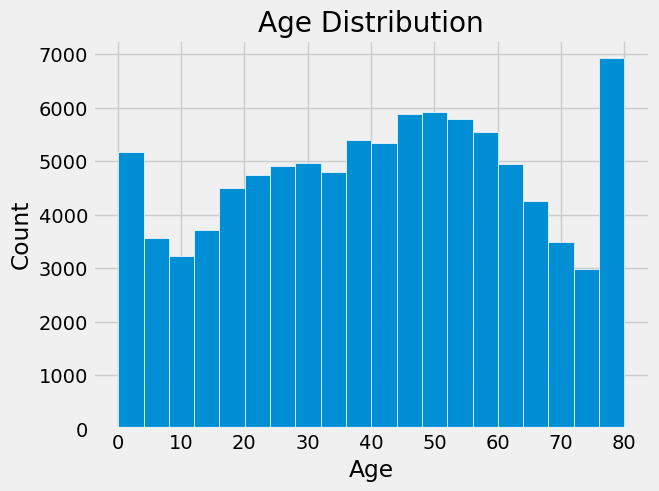

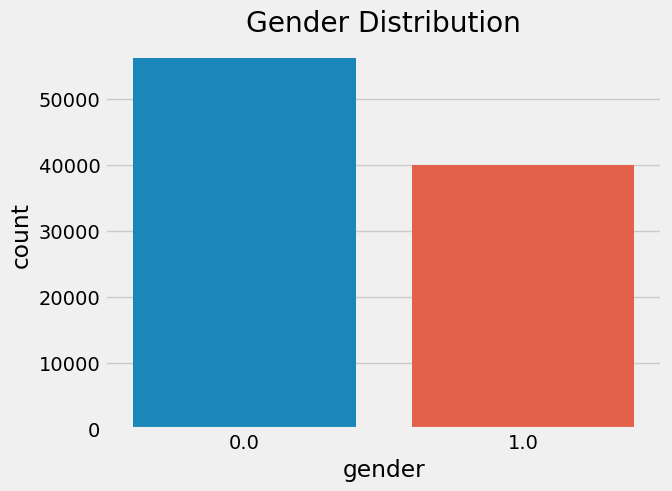

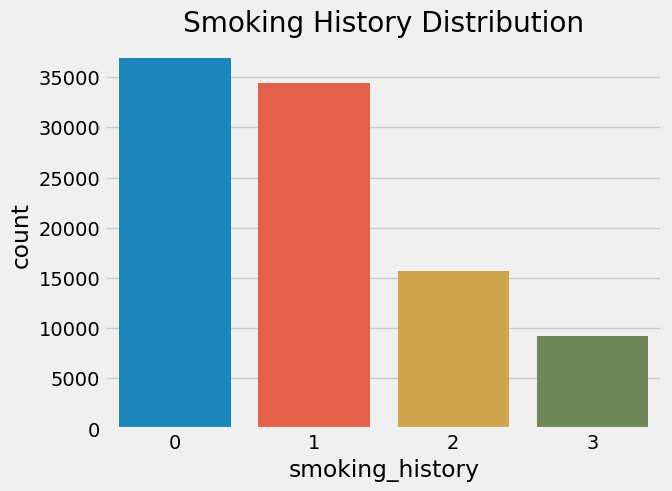

In [16]:
#Demographic Distribution
plt.style.use('fivethirtyeight')
plt.hist(dataset['age'], bins=20, ec = 'white')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

sns.countplot(x = 'gender', data = dataset)
plt.title('Gender Distribution')
plt.show()

sns.countplot(x ='smoking_history', data = dataset)
plt.title('Smoking History Distribution')
plt.show()

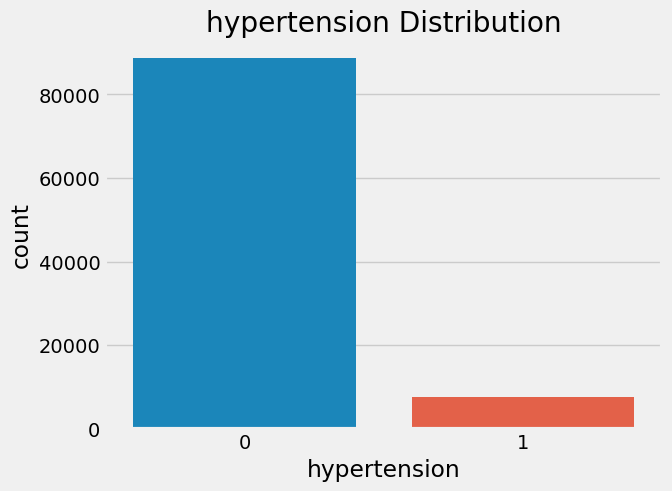

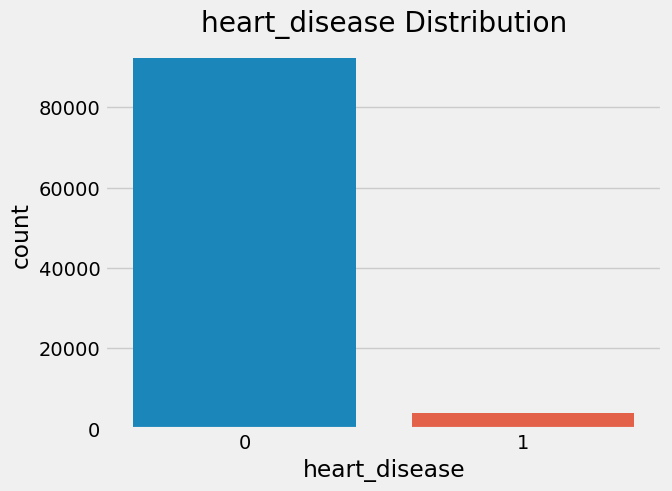

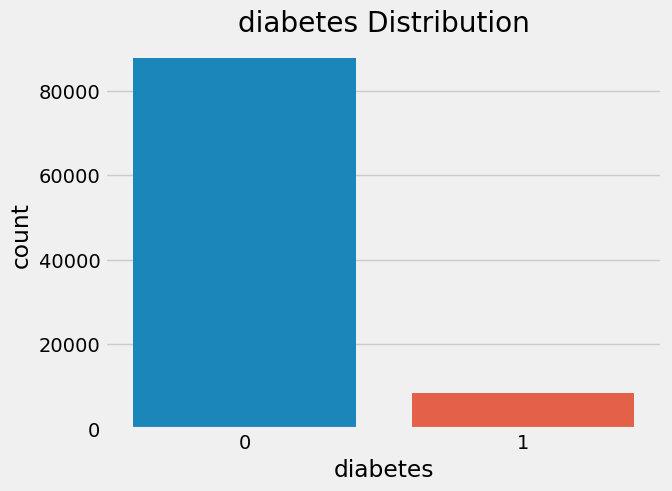

In [17]:
#Disease Distribution

for column in ['hypertension', 'heart_disease', 'diabetes']:
    sns.countplot(x = column, data= dataset)
    plt.title("{} Distribution".format(column))
    plt.show()

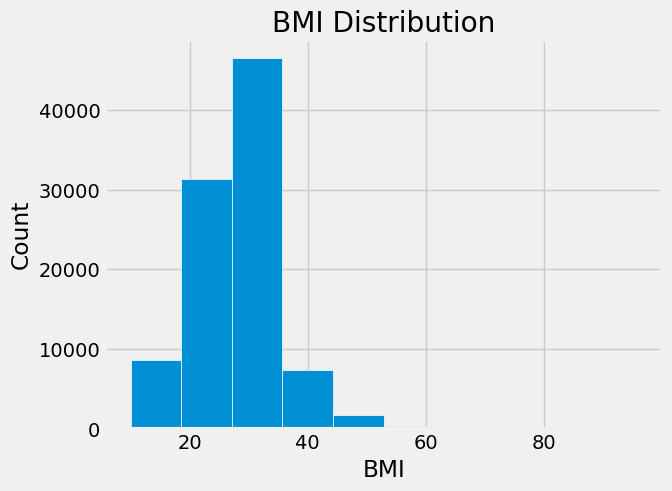

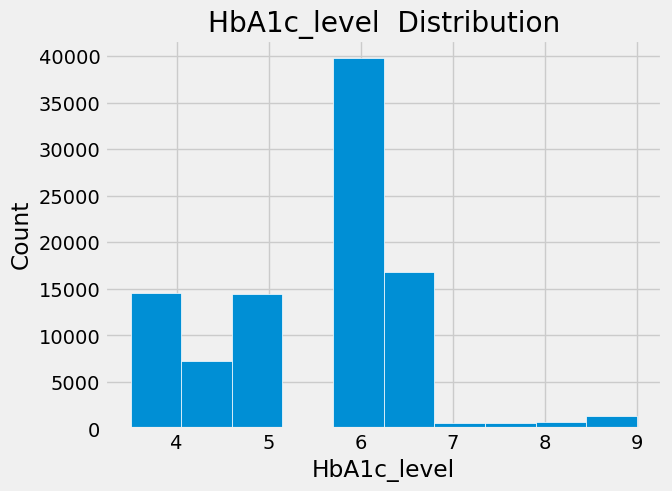

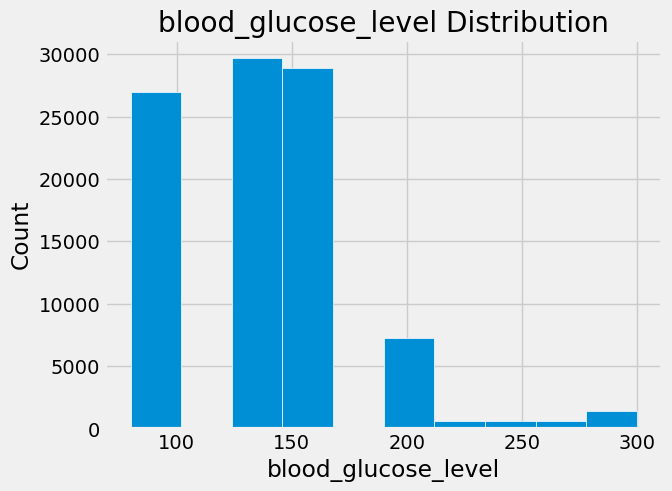

In [18]:
#Measured Stat Distribution
plt.hist(dataset['bmi'], bins=10, edgecolor = 'white')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

plt.hist(dataset['HbA1c_level'], bins=10, edgecolor = 'white')
plt.title('HbA1c_level  Distribution')
plt.xlabel('HbA1c_level')
plt.ylabel('Count')
plt.show()

plt.hist(dataset['blood_glucose_level'], bins=10, edgecolor = 'white')
plt.title('blood_glucose_level Distribution')
plt.xlabel('blood_glucose_level')
plt.ylabel('Count')
plt.show()


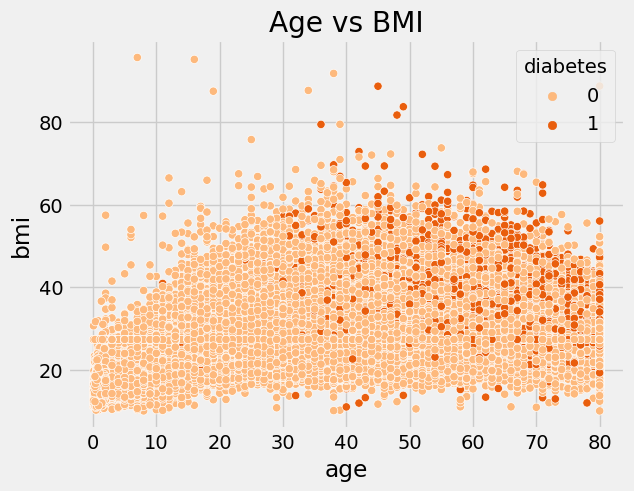

In [19]:
#Scatterplot of Age and BMI shows an increasing trend as the age and BMI goes higher
sns.scatterplot(x ='age', y ='bmi', hue ='diabetes', data= dataset, palette = 'Oranges')
plt.title('Age vs BMI')
plt.show()

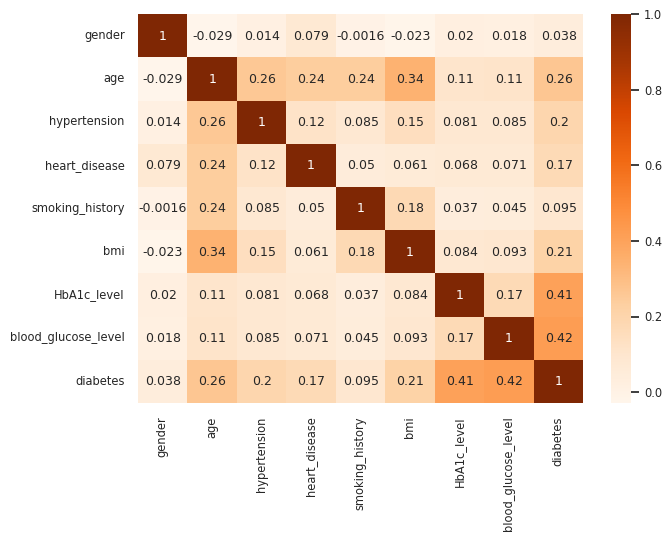

In [20]:
#Heatmap for diabetes correlation
import seaborn as sns

sns.set(font_scale = .75)
sns.heatmap(dataset.corr(), cmap = 'Oranges', annot = True,
                xticklabels=dataset.columns,
                yticklabels=dataset.columns)

plt.show()

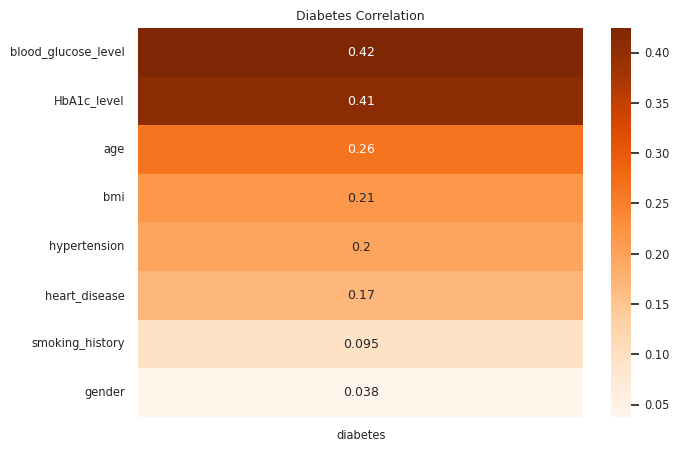

In [21]:
#Features with high correlation to diabetes in descending order
correlation = dataset.corr()
target_correlation = correlation['diabetes'].drop('diabetes').sort_values(ascending = False)
sns.heatmap(target_correlation.to_frame(), cmap="Oranges", annot=True)
plt.title('Diabetes Correlation')
plt.show()

<B><font size = 3>Training-Test Split</B></font>

In [22]:
#Creates the training and test set on an 80-20 split

X = dataset.drop(["diabetes"], axis = 1).values
y = dataset["diabetes"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#X_train: features for the training data
#X_test: features for testing data
#y_train: Dependent variables for training data
#y_test: Independent variable for testing data

<B><font size = 3>Feature Scaling</B></font>

In [23]:
#Standardize the features under the same scale and range

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<B><font size = 3>Model Building</B></font>

In [24]:
#Creates the Random Forest Classfier Model

clf = RandomForestClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

<B><font size = 3>Performance Evaluation</B></font>

In [25]:

print(classification_report(y_test,y_pred)) #printing the accuracy of testing

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17525
           1       0.94      0.67      0.78      1701

    accuracy                           0.97     19226
   macro avg       0.95      0.83      0.88     19226
weighted avg       0.97      0.97      0.96     19226



<B><font size = 3>Hyperparameter Tuning</B></font>

In [26]:
#Basic hyperparameter grid is deployed for computational efficiency
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [5, None],
    'max_leaf_nodes': [5, None],
}

In [27]:
#Outputs the best hyperparameters based on the list provided on the parameter grid
random_search = RandomizedSearchCV(RandomForestClassifier(),
                                   param_grid)
random_search.fit(X_train, y_train)
print(random_search.best_estimator_)

RandomForestClassifier(criterion='log_loss', max_depth=5)


In [28]:
#Creates a new random forest using the recommended hyperparameter settings

clf = RandomForestClassifier(max_depth=5, max_features='log2', max_leaf_nodes=5)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17525
           1       1.00      0.65      0.79      1701

    accuracy                           0.97     19226
   macro avg       0.98      0.83      0.89     19226
weighted avg       0.97      0.97      0.97     19226



The new hyperparameters provided a marginal boost in overall model performance. We can infer that the default hyperparameters of Random Forest Classifier is already good enough

In [29]:
#Show the strongest predictors in descending order

importances = list(clf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(dataset.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]


Variable: HbA1c_level          Importance: 0.53
Variable: blood_glucose_level  Importance: 0.39
Variable: age                  Importance: 0.04
Variable: hypertension         Importance: 0.02
Variable: bmi                  Importance: 0.02
Variable: gender               Importance: 0.0
Variable: heart_disease        Importance: 0.0
Variable: smoking_history      Importance: 0.0


[None, None, None, None, None, None, None, None]

<B><font size = 3>Cross Validation</B></font>

In [30]:
from sklearn.model_selection import KFold, cross_val_score
clf = RandomForestClassifier(random_state=42)
k_folds = KFold(n_splits = 10)

scores = cross_val_score(clf, X, y, cv = k_folds)

In [31]:
#Output the cross validation scores and averages
print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.96868823 0.96879226 0.96920836 0.96858421 0.96494331 0.96639967
 0.96972849 0.97004057 0.96941323 0.96795672]
Average CV Score:  0.9683755057729556
Number of CV Scores used in Average:  10


In [32]:
#Validation using Mean Absolute Error

my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))
                             ])

scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

MAE scores:
 [0.05015913 0.05073227 0.05242102 0.05042357 0.05154866]


In [33]:
print("Average MAE score (across experiments):")
print(scores.mean())

Average MAE score (across experiments):
0.051056930636324674
